# HMM build and analysis

Here we will construct and analyze HMM models using MSA as the input data. We will utilize several databases as sources to enhance our analysis and gain valuable insights from the generated HMM profiles.


In [54]:
import re
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from functions import get_fasta

In [222]:
# Path and input parameters
local_path = "/Users/alina/HMM/"
q_id = "Q9BYF1"
hmm_file = f'{local_path}outputs/hmms/{q_id}.hmm'
align_file = f'{local_path}outputs/alignments/blast/{q_id}_blast.fasta'

Using the MSA in .fasta format as an input data, we generate HMM model with `hmmbuild` command.

In [223]:
# Build HMM 
!hmmbuild {hmm_file} {align_file}

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             /Users/alina/HMM/outputs/alignments/blast/Q9BYF1_blast.fasta
# output HMM file:                  /Users/alina/HMM/outputs/hmms/Q9BYF1.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     Q9BYF1_blast           201   805   805     0.49  0.592 

# CPU time: 0.29u 0.00s 00:00:00.28 Elapsed: 00:00:00.29


Here we should pay attention at the occasional difference between the values of `alen` and `mlen` which stand for aligned sequence and consensus sequence lengths respectfully. If they differ, we handle the sequences with the deletions.

In [224]:
# Analysis of the model
!hmmstat {hmm_file}

# hmmstat :: display summary statistics for a profile file
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
#
# idx  name                 accession        nseq eff_nseq      M relent   info p relE compKL
# ---- -------------------- ------------ -------- -------- ------ ------ ------ ------ ------
1      Q9BYF1_blast         -                 201     0.49    805   0.59   0.56   0.53   0.01


In this part, we analyze the statistics of the generated HMM and focus on key metrics:
- `eff_nseq`: effective sequence number. The smaller value is suggesting a relatively low similarity among the sequences.
- `relent`: relative entropy of the match state. The value is 0.59, indicating a moderate conservation of residues.
- `compKL`: Kullback-Leibler divergence from the average composition. The value is low, indicating a better alignment fit with the background model. 

## 1. HMMsearch

After building the model, our objective is to assess if overlaps with the profiles in Pfam exist. Then, we enrich the model by utilizing a protein database such as the Reference Proteome. For both databases, we generate dataframes containing the most significant sequences, utilizing a default E-value threshold of 0.01.

### Pfam

If the HMMsearch against Pfam results in overlapping hits, it's a sign to analyse them more thoroughly.

In [225]:
# HMM search against Pfam
!hmmsearch {hmm_file} {local_path}databases/Pfam-A.seed > hmmsearch_pfam.txt # search against the alignments database (stockholm format)

In [226]:
with open('hmmsearch_pfam.txt', 'r') as file:
    lines = file.readlines()

# Extract the column names
column_names = ["E-value_fs", "score_fs", "bias_fs", "E-value_bd", "score_bd", "bias_bd", "exp", "N", "Sequence"]
inclusion_threshold_index = lines.index('  ------ inclusion threshold ------\n') # the default E-value is 0.01

# Extract the data rows
data_rows = [line.split() for line in lines[14:inclusion_threshold_index]]

# Create the DataFrame
stats_pfam = pd.DataFrame(data_rows, columns=column_names)
stats_pfam[["Sequence", "Regions"]] = stats_pfam["Sequence"].str.split("/", expand=True)
print(f"The total number of Pfam hits: {len(stats_pfam)}, the number of unique sequences: {stats_pfam.Sequence.nunique()}")
stats_pfam.head(10)

The total number of Pfam hits: 89, the number of unique sequences: 82


,E-value_fs,score_fs,bias_fs,E-value_bd,score_bd,bias_bd,exp,N,Sequence,Regions
0,0,1346.4,11.3,0,1346.3,11.3,1.0,1,F7AH40_MACMU,19-606
1,0,1326.5,8.3,0,1326.3,8.3,1.0,1,Q2WG88_MUSPF,19-606
2,0,1290.2,8.5,0,1290.0,8.5,1.0,1,H0WMI5_OTOGA,19-606
3,0,1274.2,9.0,0,1274.1,9.0,1.0,1,G1PXH7_MYOLU,19-606
4,0,1269.7,4.9,0,1269.6,4.9,1.0,1,G3T6Q2_LOXAF,19-601
5,2.4e-188,633.6,8.1,2.7e-188,633.4,8.1,1.0,1,G1KNF0_ANOCA,52-635
6,5.1e-184,619.3,3.8,5.8e-184,619.1,3.8,1.0,1,E9H130_DAPPU,29-608
7,1.6e-183,617.6,0.7,1.9e-183,617.4,0.7,1.0,1,ACE_HUMAN,40-623
8,2.6e-183,616.9,6.0,3.3e-183,616.6,6.0,1.0,1,W5N3G5_LEPOC,43-625
9,2e-182,614.0,6.5,2.5e-182,613.7,6.5,1.0,1,F1NYM0_CHICK,28-609


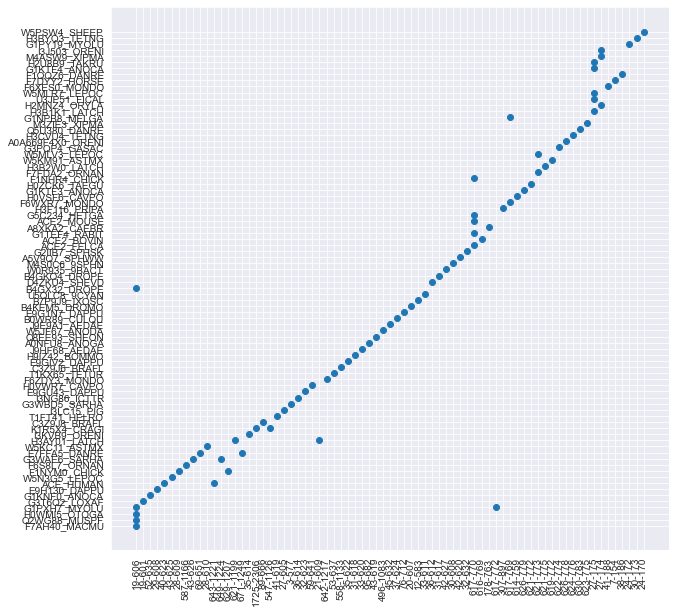

In [227]:
plt.show()
figure(figsize=(10, 10))
plt.scatter(stats_pfam['Regions'], stats_pfam['Sequence'])
plt.xticks(rotation="vertical")
plt.show()

The `hmmsearch` output displays the top hits of sequences, where a lower E-value indicates a more significant hit.

We are interested in `exp` and `N` columns which represent the expected number of domains and the actual number of identified domains. This two numbers should be about the same.

### Reference Proteome

The same procedure will be applied to the Reference Proteome database. The objective here is to enhance the quality of the model by conducting additional model training using a larger set of homologous sequences.

In [228]:
# HMM search against Reference Proteome
!hmmsearch {hmm_file} {local_path}databases/rp-seqs-15.fasta > hmmsearch_rp.txt

In [230]:
with open('hmmsearch_rp.txt', 'r') as file:
    lines = file.readlines()

# Extract the column names
column_names = lines[12].split()
inclusion_threshold_index = lines.index('  ------ inclusion threshold ------\n')

# Extract the data rows
data_rows = [line.split() for line in lines[14:inclusion_threshold_index]]
data_rows = [row[:9] + [' '.join(row[9:])] for row in data_rows]

# Create the DataFrame
stats_rp = pd.DataFrame(data_rows, columns=column_names)
len(stats_rp)
print(f"The total number of Reference Proteome hits: {len(stats_rp)}, the number of unique sequences: {stats_rp.Sequence.nunique()}")
stats_rp.head(10)

The total number of Reference Proteome hits: 801, the number of unique sequences: 801


,E-value,score,bias,E-value,score,bias,exp,N,Sequence,Description
0,0,3317.4,77.0,2.9e-172,583.6,2.4,6.0,6,A0A8B8DNB2,A0A8B8DNB2_CRAVI^|^^|^Angiotensin-converting enzy
1,0,1864.3,62.4,2.7e-147,501.1,6.0,6.0,6,A0A443RGV1,A0A443RGV1_9ACAR^|^^|^Angiotensin-converting enzy
2,0,1850.4,17.4,1.6e-173,587.9,0.9,5.0,5,A0A2T7PQW4,A0A2T7PQW4_POMCA^|^^|^Angiotensin-converting enzy
3,0,1849.5,59.8,9.4e-146,496.0,10.3,4.0,4,A0A8K0C9Y9,A0A8K0C9Y9_9COLE^|^^|^Uncharacterized protein {EC
4,0,1805.6,9.3,0,1805.5,9.3,1.0,1,A0A2K5X283,A0A2K5X283_MACFA^|^^|^Angiotensin-converting enzy
5,0,1801.4,6.9,0,1801.2,6.9,1.0,1,Q9BYF1,ACE2_HUMAN^|^T14762^|^Processed angiotensin-conve
6,0,1781.1,5.5,0,1780.9,5.5,1.0,1,A0A2K6SBD4,A0A2K6SBD4_SAIBB^|^^|^Angiotensin-converting enzy
7,0,1744.5,6.8,0,1744.3,6.8,1.0,1,Q8R0I0,ACE2_MOUSE^|^^|^Processed angiotensin-converting
8,0,1736.6,7.3,0,1736.4,7.3,1.0,1,C7ECU5,C7ECU5_RAT^|^^|^Angiotensin-converting enzyme {EC
9,0,1736.6,7.3,0,1736.4,7.3,1.0,1,Q5EGZ1,ACE2_RAT^|^^|^Processed angiotensin-converting en


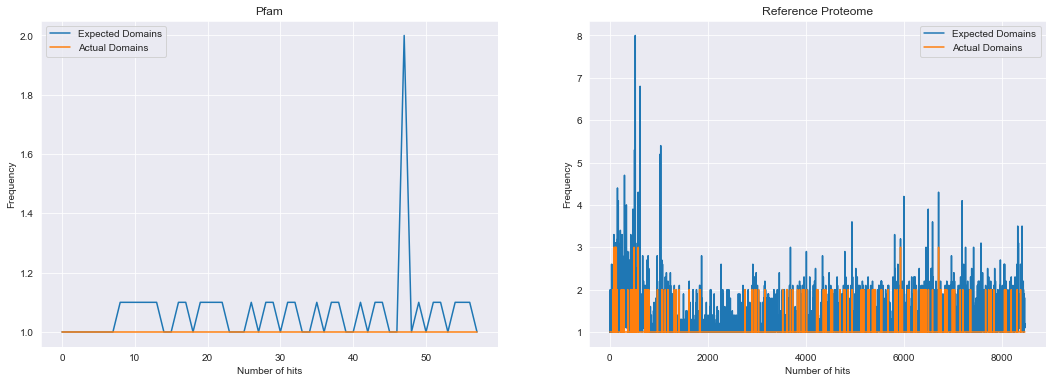

In [135]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(stats_pfam['exp'].astype(float), label='Expected Domains')
ax1.plot(stats_pfam['N'].astype(float), label='Actual Domains')

ax2.plot(stats_rp['exp'].astype(float), label='Expected Domains')
ax2.plot(stats_rp['N'].astype(float), label='Actual Domains')

ax1.set_xlabel('Number of hits')
ax1.set_ylabel('Frequency')
ax1.set_title('Pfam')
ax1.legend()

ax2.set_xlabel('Number of hits')
ax2.set_ylabel('Frequency')
ax2.set_title('Reference Proteome')
ax2.legend()

plt.show()

In [72]:
# Retrieve a query sequence
query_sequence = get_fasta(q_id)
query_lines = query_sequence.split("\n")
query_sequence = "".join(query_lines[1:])

In [26]:
# # Retrieve the unaligned sequence from the local machine
# rpalign = f'{local_path}outputs/alignments/{q_id}_rpalign.fasta'

# with open(rpalign, 'w') as fout:
#     # Write the query sequence to the output file as the first line
#     fout.write(">{}\n{}\n".format(q_id, query_sequence))
    
#     for index, row in stats_rp.iterrows():
#         accession = row['Sequence']
#         sequence = get_fasta(accession)
#         if q_id == accession: # remove duplicates
#             continue
#         fout.write(sequence)

## 2. HHblits

HHblits is used for profile-profile sequence alignment. It compares a profile against a target sequence database to find homologous sequences.

In [73]:
# HHblits against Pfam
!hhblits -i {align_file} -d {local_path}databases/pfam -o hhblits_pfam.txt # on alignment

- 09:25:41.961 INFO: Searching 19632 column state sequences.

- 09:25:42.676 INFO: /Users/alina/HMM/outputs/alignments/blast/Q9BYI3_blast.fasta is in A2M, A3M or FASTA format

- 09:25:42.680 INFO: Iteration 1

- 09:25:42.923 INFO: Prefiltering database

- 09:25:43.379 INFO: HMMs passed 1st prefilter (gapless profile-profile alignment)  : 452

- 09:25:43.387 INFO: HMMs passed 2nd prefilter (gapped profile-profile alignment)   : 141

- 09:25:43.387 INFO: HMMs passed 2nd prefilter and not found in previous iterations : 141

- 09:25:43.387 INFO: Scoring 141 HMMs using HMM-HMM Viterbi alignment

- 09:25:43.421 INFO: Alternative alignment: 0

- 09:25:47.186 INFO: 141 alignments done

- 09:25:47.187 INFO: Alternative alignment: 1

- 09:25:47.652 INFO: 28 alignments done

- 09:25:47.653 INFO: Alternative alignment: 2

- 09:25:47.653 INFO: Alternative alignment: 3

- 09:25:47.988 INFO: Premerge done

- 09:25:47.988 INFO: Realigning 10 HMM-HMM alignments using Maximum Accuracy algorithm

- 09:25

- `Hit`: contains information about Pfam identifier (starts with PF...), the abbreviated and full name of the domain.
- `Prob`: the probability of the match between the query sequence and the template sequence.
- `E-value`: the expected number of false positive matches that could occur by chance.
- `P-value`: the probability of obtaining a match with a score as good as or better than the observed score purely by chance.
Similar as `E-value`, the lower `P-value` indicate more significant matches.
- `Score`: the quality of the alignment between the query and template sequences.
- `SS (Secondary Structure)`: the predicted secondary structure of the aligned residues in the template sequence.
- `Cols`: the number of aligned columns or residues in the alignment between the query and template sequences.
- `Query HMM`: indicates position matches within HMM profile (input).
- `Template HMM`: indicates position matches within HMM profile (database).
Usually the length of template HMM is bigger than the length of query HMM.

In [76]:
with open('hhblits_pfam.txt', 'r') as file:
    lines = file.readlines()

# Extract the column names
column_names = lines[8].split()[:-4] + ['Query HMM', 'Template HMM']

# Extract the data rows
data_rows = [line.split() for line in lines[9:19]] 
data_rows = [[row[0]] + [' '.join(row[1:4])] + row[7:14] + [' '.join(row[14:16])] 
             for row in data_rows]

# Create the DataFrame
hhblits_stats = pd.DataFrame(data_rows, columns=column_names)
print(f"The total number of HHblits hits on Pfam: {len(hhblits_stats)}")
hhblits_stats

The total number of HHblits hits on Pfam: 10


,No,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM
0,1,PF09790.12 ; Hyccin,4.3E-81,9.5E-85,625.1,0.0,295,22-330,1-324,(324)
1,2,PF06254.14 ; YdaT_toxin,16,0.0035,24.7,0.0,28,58-85,9-36,(88)
2,3,PF11865.11 ; DUF3385,22,0.0051,24.9,0.0,51,36-90,83-134,(157)
3,4,PF01474.19 ; DAHP_synth_2,29,0.0063,30.1,0.0,81,391-472,55-135,(440)
4,5,PF01533.19 ; Tospo_nucleocap,0.0098,27.3,0.0,59,160-218,144-205,(246),
5,6,PF08747.14 ; BrxB,3.3,59,0.013,22.0,0.0,42,5-46,13-54 (125)
6,7,PF14222.9 ; MOR2-PAG1_N,59,0.013,28.2,0.0,35,55-91,228-262,(585)
7,8,PF06580.16 ; His_kinase,55,0.014,18.4,0.0,42,229-270,7-48,(80)
8,9,PF18215.4 ; Rtt106_N,67,0.014,18.9,0.0,15,53-67,24-38,(47)
9,10,PF15946.8 ; DUF4754,2.6,80,0.017,20.1,0.0,44,235-278,33-76 (80)


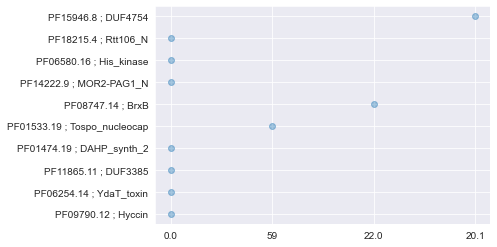

In [75]:
plt.scatter(hhblits_stats['Score'], hhblits_stats['Hit'], alpha=0.4)
plt.show()